# Sentimental Analysis for E-Commerce Websites

#Team 16 
**Sunny Sumanth Dodda**<br>
**Sai Krishna Boyinapally**<br>
**Jatin Raj Thodupunuri**<br>
**Poojitha Achanta**<br>


**Importing Libraries**

In [181]:
# !pip install pyforest
# 1-Import Libraies
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.compose import make_column_transformer

# Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Importing plotly and cufflinks in offline mode
import plotly.express as px
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# !pip install termcolor
import colorama
from colorama import Fore, Style  # maakes strings colored
from termcolor import colored

import ipywidgets
from ipywidgets import interact

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
from wordcloud import WordCloud

**Exploratory Data Analysis**

In [182]:
## Some Useful Functions

###############################################################################

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    
        
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .9 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('-'*79, 'red', attrs=['bold']), sep='')

def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored("Duplicates were dropped!"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')     
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary will drop related columns!', attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
        
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print('New shape after missing value control:', df.shape)
        
###############################################################################

# To view summary information about the column

def first_look(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False))

In [183]:
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length...",5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i co...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses


In [184]:
first_looking(df)
duplicate_values(df)
drop_columns(df,[])
drop_null(df, 90)

Shape:(23486, 11)
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB
None
------------------------------------------

In [185]:
df.drop(['unnamed:_0', 'clothing_id'], axis = 1, inplace=True)

In [186]:
df = df.rename(columns = {'Review Text' : 'text', 'recommended_ind' : 'recommended', 
                          'positive_feedback_count' : 'feedback_count', 'division_name' : 'division', 
                          'department_name' : 'department', 'class_name' :'class'})

In [187]:
df.describe(include=object).T

,count,unique,top,freq
title,19676,13993,Love it!,136
review_text,22641,22634,Perfect fit and i've gotten so many compliments. i buy all my suits from here now!,3
division,23472,3,General,13850
department,23472,6,Tops,10468
class,23472,20,Dresses,6319


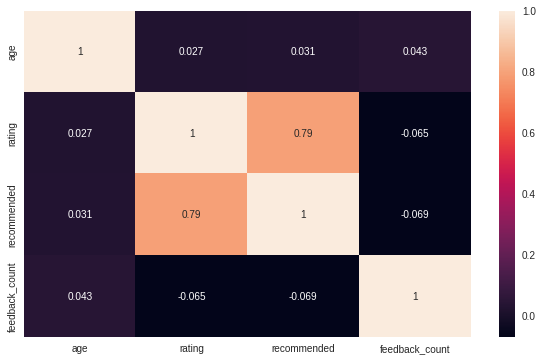

In [188]:
sns.heatmap(df.corr(), annot=True);

1    19314
0     4172
Name: recommended, dtype: int64


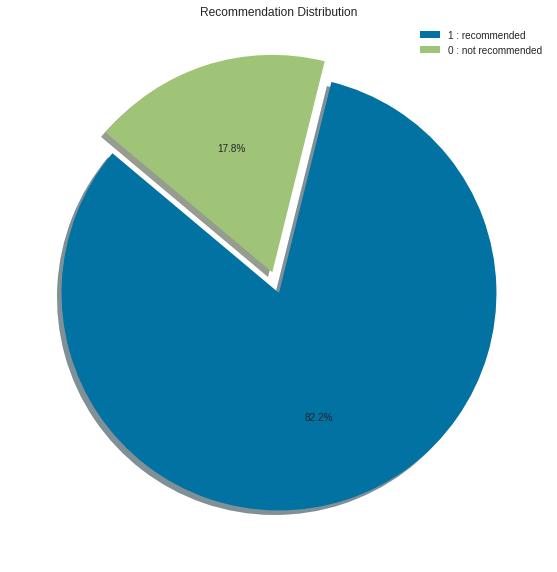

In [189]:
# recommended : 
# Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

print(df.recommended.value_counts())

plt.figure(figsize=(10,10))

explode = [0,0.1]
plt.pie(df.recommended.value_counts(), explode=explode,autopct='%1.1f%%', shadow=True,startangle=140)
plt.legend(labels=['1 : recommended','0 : not recommended'])
plt.title('Recommendation Distribution')
plt.axis('off');

**Feature Selection and Data Cleaning**

In [190]:
df_ml = df.copy()

# df_ml = df[['review_text', 'recommended']].copy()

In [191]:
drop_columns = ['age', 
                'title', 
                'rating',
                'feedback_count', 
                'division',
                'department',
                'class']

In [192]:
df_ml.drop(drop_columns, axis = 1, inplace = True)

In [193]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  22641 non-null  object
 1   recommended  23486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 367.1+ KB


In [194]:
df_ml.rename(columns = {'review_text':'text', 'recommended':'recommend'}, inplace = True)

In [195]:
df_ml.columns

Index(['text', 'recommend'], dtype='object')

In [196]:
missing_values(df_ml)

,Missing_Number,Missing_Percent
text,845,0.036


In [197]:
df_ml.isnull().melt(value_name="missing")

,variable,missing
0,text,False
1,text,False
2,text,False
3,text,False
4,text,False
...,...,...
46967,recommend,False
46968,recommend,False
46969,recommend,False
46970,recommend,False


<Figure size 720x360 with 0 Axes>

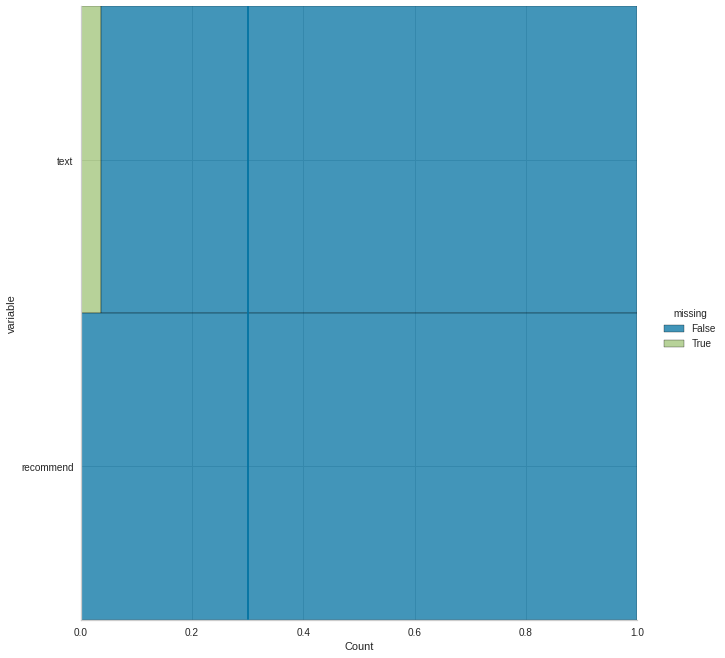

In [198]:
plt.figure(figsize = (10, 5))
sns.displot(data = df_ml.isnull().melt(value_name = "missing"),y = "variable",hue = "missing",multiple = "fill",height = 9.25)
plt.axvline(0.3, color = "b");

In [199]:
df_ml = df_ml.dropna()

# df_ml = df_ml.dropna(subset=['text'], axis=0)
# df_ml = df_ml.reset_index(drop=True)

In [200]:
missing_values(df_ml)

,Missing_Number,Missing_Percent


In [201]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       22641 non-null  object
 1   recommend  22641 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 530.6+ KB


In [202]:
df_ml["text"].str.isspace().sum()
df_ml[df_ml["text"].str.isspace() == True].index

Int64Index([], dtype='int64')

**Text Mining**<br>
Tokenization, Noise Removal and Lexicon Normalization

In [203]:
df_ml.head()

,text,recommend
0,Absolutely wonderful - silky and sexy and comfortable,1
1,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length...",1
2,I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i co...,0
3,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",1
4,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,1


In [204]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [205]:
def cleaning(data):

    text_tokens = word_tokenize(data.replace("'", "").lower()) #1. Tokenize
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]  #2. Remove Puncs
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words] #3. Removing Stopwords
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]  #4. lemma
    return " ".join(text_cleaned) #joining

In [206]:
nltk.download('wordnet')
df_ml["text"] = df_ml["text"].apply(cleaning)
df_ml["text"].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0                                                                                                                                                                absolutely wonderful silky sexy comfortable
1                       love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite love length hit little knee would definitely true midi someone truly petite
2    high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium overall top half comfortable fit nicely bottom ha...
3                                                                                                                   love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment
4                                                                                             shirt flattering due adjustable front tie perfect length wear legging sleeveless pair 

**WordCloud - Repetition of Words**

In [207]:
df_ml[df_ml["recommend"] == 0].head(3)

,text,recommend
2,high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium overall top half comfortable fit nicely bottom ha...,0
5,love tracy reese dress one petite foot tall usually wear brand dress pretty package lot dress skirt long full overwhelmed small frame stranger alteration shortening narrowing skirt would take away...,0
10,dress run small esp zipper area run ordered sp typically fit tight material top look feel cheap even pulling cause rip fabric pretty disappointed going christmas dress year needle say going back,0


In [208]:
df_ml[df_ml["recommend"] == 1].head(3)

,text,recommend
0,absolutely wonderful silky sexy comfortable,1
1,love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite love length hit little knee would definitely true midi someone truly petite,1
3,love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment,1


In [209]:
" ".join(df_ml["text"]).split()

['absolutely',
 'wonderful',
 'silky',
 'sexy',
 'comfortable',
 'love',
 'dress',
 'sooo',
 'pretty',
 'happened',
 'find',
 'store',
 'im',
 'glad',
 'bc',
 'never',
 'would',
 'ordered',
 'online',
 'bc',
 'petite',
 'bought',
 'petite',
 'love',
 'length',
 'hit',
 'little',
 'knee',
 'would',
 'definitely',
 'true',
 'midi',
 'someone',
 'truly',
 'petite',
 'high',
 'hope',
 'dress',
 'really',
 'wanted',
 'work',
 'initially',
 'ordered',
 'petite',
 'small',
 'usual',
 'size',
 'found',
 'outrageously',
 'small',
 'small',
 'fact',
 'could',
 'zip',
 'reordered',
 'petite',
 'medium',
 'overall',
 'top',
 'half',
 'comfortable',
 'fit',
 'nicely',
 'bottom',
 'half',
 'tight',
 'layer',
 'several',
 'somewhat',
 'cheap',
 'net',
 'layer',
 'imo',
 'major',
 'design',
 'flaw',
 'net',
 'layer',
 'sewn',
 'directly',
 'zipper',
 'c',
 'love',
 'love',
 'love',
 'jumpsuit',
 'fun',
 'flirty',
 'fabulous',
 'every',
 'time',
 'wear',
 'get',
 'nothing',
 'great',
 'compliment',
 's

In [210]:
positive_words =" ".join(df_ml[df_ml["recommend"] == 1].text).split()
positive_words

['absolutely',
 'wonderful',
 'silky',
 'sexy',
 'comfortable',
 'love',
 'dress',
 'sooo',
 'pretty',
 'happened',
 'find',
 'store',
 'im',
 'glad',
 'bc',
 'never',
 'would',
 'ordered',
 'online',
 'bc',
 'petite',
 'bought',
 'petite',
 'love',
 'length',
 'hit',
 'little',
 'knee',
 'would',
 'definitely',
 'true',
 'midi',
 'someone',
 'truly',
 'petite',
 'love',
 'love',
 'love',
 'jumpsuit',
 'fun',
 'flirty',
 'fabulous',
 'every',
 'time',
 'wear',
 'get',
 'nothing',
 'great',
 'compliment',
 'shirt',
 'flattering',
 'due',
 'adjustable',
 'front',
 'tie',
 'perfect',
 'length',
 'wear',
 'legging',
 'sleeveless',
 'pair',
 'well',
 'cardigan',
 'love',
 'shirt',
 'aded',
 'basket',
 'hte',
 'last',
 'mintue',
 'see',
 'would',
 'look',
 'like',
 'person',
 'store',
 'pick',
 'went',
 'teh',
 'darkler',
 'color',
 'pale',
 'hte',
 'color',
 'really',
 'gorgeous',
 'turn',
 'mathced',
 'everythiing',
 'trying',
 'prefectly',
 'little',
 'baggy',
 'hte',
 'x',
 'hte',
 'msal

In [211]:
negative_words =" ".join(df_ml[df_ml["recommend"] == 0].text).split()
negative_words

['high',
 'hope',
 'dress',
 'really',
 'wanted',
 'work',
 'initially',
 'ordered',
 'petite',
 'small',
 'usual',
 'size',
 'found',
 'outrageously',
 'small',
 'small',
 'fact',
 'could',
 'zip',
 'reordered',
 'petite',
 'medium',
 'overall',
 'top',
 'half',
 'comfortable',
 'fit',
 'nicely',
 'bottom',
 'half',
 'tight',
 'layer',
 'several',
 'somewhat',
 'cheap',
 'net',
 'layer',
 'imo',
 'major',
 'design',
 'flaw',
 'net',
 'layer',
 'sewn',
 'directly',
 'zipper',
 'c',
 'love',
 'tracy',
 'reese',
 'dress',
 'one',
 'petite',
 'foot',
 'tall',
 'usually',
 'wear',
 'brand',
 'dress',
 'pretty',
 'package',
 'lot',
 'dress',
 'skirt',
 'long',
 'full',
 'overwhelmed',
 'small',
 'frame',
 'stranger',
 'alteration',
 'shortening',
 'narrowing',
 'skirt',
 'would',
 'take',
 'away',
 'embellishment',
 'garment',
 'love',
 'color',
 'idea',
 'style',
 'work',
 'returned',
 'dress',
 'dress',
 'run',
 'small',
 'esp',
 'zipper',
 'area',
 'run',
 'ordered',
 'sp',
 'typically',

In [212]:
print("Lenght of positive words: ",len(positive_words))
print("Lenght of negative words: ",len(negative_words))

Lenght of positive words:  523005
Lenght of negative words:  118210


In [213]:
review_text = df_ml["text"]

In [214]:
all_words = " ".join(review_text)

In [215]:
all_words[:100]

'absolutely wonderful silky sexy comfortable love dress sooo pretty happened find store im glad bc ne'

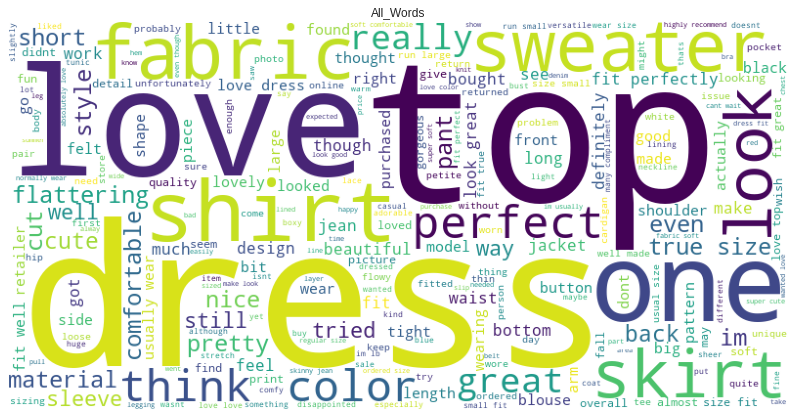

In [216]:
wordcloud = WordCloud(width = 800, height = 400, background_color = "white", max_words = 250).generate(all_words)

plt.figure(figsize = (14, 14))
plt.imshow(wordcloud)
plt.title('All_Words')
plt.axis("off")
plt.show()

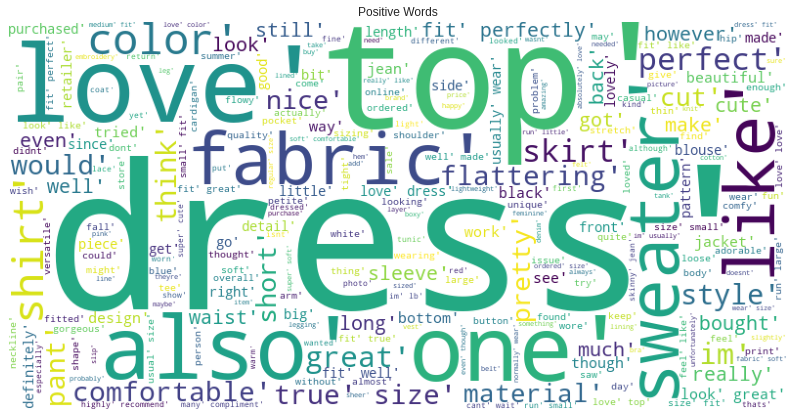

In [217]:
wordcloud = WordCloud(width = 800, height = 400, background_color = "white", max_words = 250).generate(str(positive_words))

plt.figure(figsize = (14, 14))
plt.imshow(wordcloud)
plt.title('Positive Words')
plt.axis("off")
plt.show()

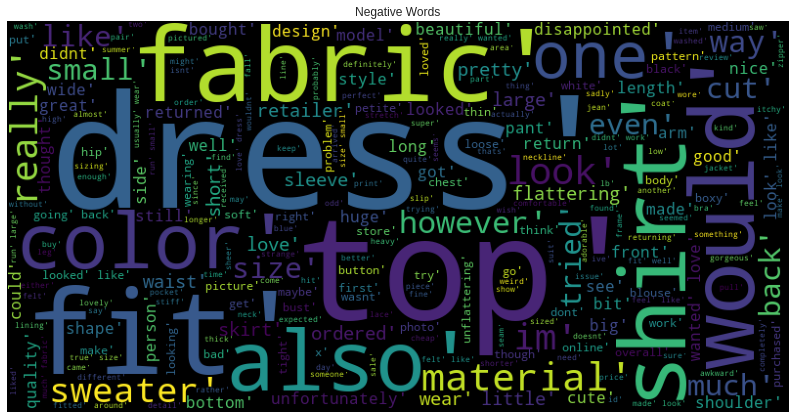

In [218]:
wordcloud = WordCloud(width = 800, height = 400, background_color = "black", max_words = 250).generate(str(negative_words))

plt.figure(figsize = (14, 14))
plt.imshow(wordcloud)
plt.title('Negative Words')
plt.axis("off")
plt.show()

In [219]:
counter_all = Counter(word_tokenize(all_words))
counter_all.most_common(50)

[('dress', 11352),
 ('fit', 10128),
 ('size', 9363),
 ('love', 8992),
 ('top', 8280),
 ('like', 7036),
 ('color', 6916),
 ('look', 6890),
 ('wear', 6520),
 ('great', 6101),
 ('im', 5968),
 ('would', 5014),
 ('fabric', 4862),
 ('small', 4589),
 ('really', 3924),
 ('ordered', 3835),
 ('little', 3773),
 ('perfect', 3760),
 ('one', 3704),
 ('flattering', 3485),
 ('soft', 3322),
 ('well', 3251),
 ('back', 3186),
 ('comfortable', 3047),
 ('cute', 3030),
 ('nice', 3017),
 ('bought', 2986),
 ('beautiful', 2950),
 ('bit', 2877),
 ('material', 2811),
 ('shirt', 2791),
 ('large', 2791),
 ('much', 2703),
 ('sweater', 2699),
 ('length', 2637),
 ('run', 2631),
 ('jean', 2598),
 ('also', 2583),
 ('work', 2527),
 ('petite', 2430),
 ('got', 2426),
 ('long', 2400),
 ('short', 2361),
 ('waist', 2306),
 ('quality', 2259),
 ('medium', 2233),
 ('skirt', 2220),
 ('think', 2194),
 ('pretty', 2188),
 ('even', 2166)]

In [220]:
X = df_ml["text"].values
y = df_ml["recommend"].map({0:1, 1:0}).values

In [221]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 101)

In [222]:
from sklearn.feature_extraction.text import CountVectorizer

In [223]:
vectorizer = CountVectorizer()

X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

In [224]:
X_train_count

<18112x10956 sparse matrix of type '<class 'numpy.int64'>'
	with 465725 stored elements in Compressed Sparse Row format>

In [225]:
X_test_count

<4529x10956 sparse matrix of type '<class 'numpy.int64'>'
	with 114581 stored elements in Compressed Sparse Row format>

In [226]:
len(X_train_count.toarray())

18112

In [227]:
X_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [228]:
len(X_test_count.toarray())

4529

In [229]:
X_test_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [230]:
pd.DataFrame(X_train_count.toarray(), columns = vectorizer.get_feature_names())

,aa,aaaaaaamazing,aaaaandidontwanttopayforshipping,aaaaannnnnnd,aaaahmazing,aaaahs,aaahed,ab,abbey,abby,abdomen,abdominal,abercrombie,abhor,ability,able,abnormal,abnormally,abo,abolutely,abou,abroad,abruptly,absence,abso,absolute,absolutely,absolutley,absolutly,absoluty,abstract,absurd,absurdly,abt,abundance,abused,ac,acacia,accent,accented,accenting,accentuate,accentuatea,accentuated,accentuates,accentuating,accept,acceptabl,acceptable,acceptably,accepted,accepts,access,accesso,accessorize,accessorized,accessorizes,accessorizing,accessory,accident,accidental,accidentally,acco,accomadate,accommodate,accommodated,accommodates,accommodating,accomodate,accompanies,accompany,accompanying,accomplish,accomplishing,accomplishment,accord,accordance,accordian,according,accordingly,accordion,account,accumulate,accuracy,accurate,accurately,acetate,achieve,achieved,acid,ack,acquaintance,acquiring,across,acrossed,acrylic,act,action,active,activewear,...,wth,wtih,wuality,wuzzy,wwear,wynwood,xl,xlarge,xmas,xsm,xsmall,xsp,xspetite,xspwas,xtr,xtra,xx,xxi,xxl,xxp,xxsmall,xxsp,xxx,xxxl,xxxxxs,xxxxxxxxs,yacht,yak,yall,yank,yanking,yarn,yay,ye,yea,yeah,year,yelling,yellow,yellowed,yellower,yellowish,yellowy,yep,yepeee,yes,yest,yesterday,yesteryear,yet,yey,yiddish,yield,yielded,yikes,yo,yoga,yogi,yoke,yoked,york,yoself,youd,youll,young,younger,youre,youth,youthful,youthfull,youve,yr,yuck,yucky,yumi,yummiest,yummy,yup,zag,zara,zed,zero,zig,zigzag,zigzagging,zillion,zip,zipepr,ziploc,zipped,zipper,zippered,zippie,zipping,zombie,zone,zoolanders,zoom,zooming,zuma
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [231]:
print(X_train)

['love gorgeous shade unflattering skintone make look sallow version tied dress holding horse come fantastic fit flattering tummy rib cage size generous curve give regular'
 'found store last weekend thought perfect got size small plenty space usually small long found knee length zoom see detail work along front edge complement pretty openwork back pocket btw worn everything summer let hope blend wash ok'
 'negative thing say color person different much coral pink rosy pink fine tad unexpected ordered size fit perfectly chest laser cut out yoke add nice feminine unique touch otherwise basic top cant wait wear'
 ... 'wanted love skirt good quality front loose flap exposing return'
 'absolutely love top soft comfortable perfectly flowy definitely favorite go casual summer top'
 'purchased blue version store nice royal blue navy although could worn navy thought fit flattering middle piece pleat le obvious blue purple tie neck untied still low cut']


In [232]:
print(X_test)

['dont normally write review purchased dress white different size dress flaw hem uneven three dress poorly sewn shame looked awesome online disappointed'
 'love style coat way fit model reality cut straight hoping darting slimmer silhouette cinching belt make coat bunch unattractively sized think would look better im concerned shoulder fit fabric wool bit itchy lined lining jersey poly blend belt flimsy ugly string loop cheapens look coat b'
 'received dress birthday gift completely love thing wish id known mean deal breaker first kind see model shot keyhole neckline sewn shut completely open didnt cause problem woman may comfortable dress didnt zipper pullover band run around waist little stretch'
 ... 'super cute fitted baggy overall yesteryear love'
 'love look tee casual interesting detail make flattering wearable plain tee tried regular size x large frumpy initial disappointed however promo decided try xx made huge difference size great look like model ordered coral beautiful colo

In [233]:
print(y_train)

[0 0 0 ... 1 0 0]


In [234]:
print(y_test)

[1 0 0 ... 0 0 0]


In [235]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score, average_precision_score

In [236]:
def eval(model, X_train, X_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print(confusion_matrix(y_test, y_pred))
    print("Test_Set")
    print(classification_report(y_test,y_pred))
    print("Train_Set")
    print(classification_report(y_train,y_pred_train))
    plot_confusion_matrix(model, X_test, y_test, cmap="plasma")

**Logistic Regression**

In [237]:
from sklearn.linear_model import LogisticRegression

logreg_count = LogisticRegression(C = 0.1, max_iter = 1000, class_weight = 'balanced', random_state = 101)
logreg_count.fit(X_train_count,y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   random_state=101)

LogReg_Count Model
------------------
[[3208  501]
 [ 122  698]]
Test_Set
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      3709
           1       0.58      0.85      0.69       820

    accuracy                           0.86      4529
   macro avg       0.77      0.86      0.80      4529
weighted avg       0.89      0.86      0.87      4529

Train_Set
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     14831
           1       0.65      0.93      0.77      3281

    accuracy                           0.90     18112
   macro avg       0.82      0.91      0.85     18112
weighted avg       0.92      0.90      0.90     18112



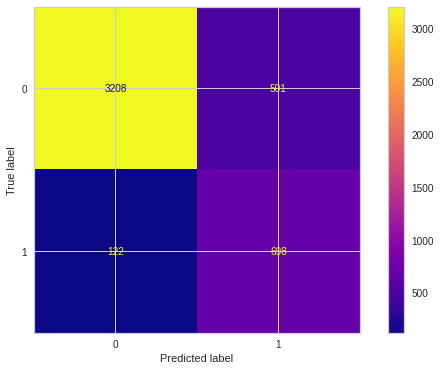

In [238]:
print("LogReg_Count Model")
print ("------------------")
eval(logreg_count, X_train_count, X_test_count)

In [239]:
import random
import pylab as pl
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

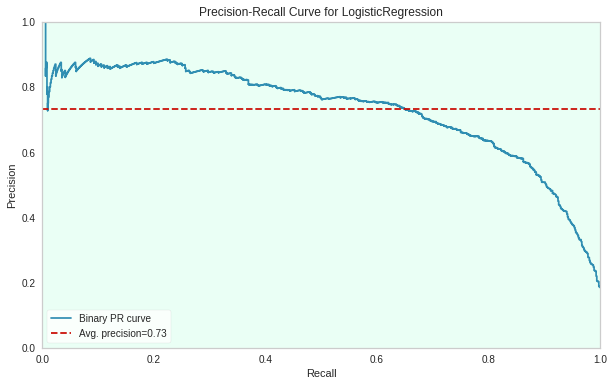

In [240]:
from yellowbrick.classifier import PrecisionRecallCurve

viz = PrecisionRecallCurve(
      LogisticRegression(C = 0.1, max_iter = 1000, class_weight= "balanced", random_state=101),
      classes = logreg_count.classes_,
      per_class = True,
      cmap = "Set1")

fig, ax = plt.subplots(figsize = (10, 6))
ax.set_facecolor('#eafff5')

viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [241]:
y_pred = logreg_count.predict(X_test_count)
log_count_rec = recall_score(y_test, y_pred, pos_label = 0, average = None)
log_count_f1 = f1_score(y_test, y_pred, pos_label = 0, average = None)
log_AP = viz.score_

In [242]:
print("viz.score_       : ", viz.score_)
print("LogReg_Count_rec : ", log_count_rec)
print("LogReg_Count_f1  : ", log_count_f1)
print("LogReg_Count_AP  : ", log_AP)

viz.score_       :  0.7318428079050375
LogReg_Count_rec :  [0.86492316 0.85121951]
LogReg_Count_f1  :  [0.91149311 0.6914314 ]
LogReg_Count_AP  :  0.7318428079050375


In [243]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label = 0),
                 'recall-0': make_scorer(recall_score, pos_label = 0),
                 'f1-0': make_scorer(f1_score, pos_label = 0),
                 'precision-1': make_scorer(precision_score, pos_label = 1),
                 'recall-1': make_scorer(recall_score, pos_label = 1),
                 'f1-1': make_scorer(f1_score, pos_label = 1)
                 }

for i, j in custom_scorer.items():
    model = LogisticRegression(C = 0.1, max_iter = 1000, class_weight = "balanced", random_state = 101)
    scores = cross_val_score(model, X_train_count, y_train, cv = 10, scoring = j).mean()
    if i == "recall-0":
        log_count_rec = scores
    elif i == "f1-0":
        log_count_f1 = scores
    print(f" {i:20} score for LogReg_Count : {scores}\n")

 accuracy             score for LogReg_Count : 0.8637374860278675

 precision-0          score for LogReg_Count : 0.9571851639346928

 recall-0             score for LogReg_Count : 0.8726318310120267

 f1-0                 score for LogReg_Count : 0.9129407323973634

 precision-1          score for LogReg_Count : 0.5887900060147659

 recall-1             score for LogReg_Count : 0.8235349173400548

 f1-1                 score for LogReg_Count : 0.6865592567745237



In [244]:
LogReg_Count_AP = viz.score_
LogReg_Count_AP

0.7318428079050375

**NaiveBayes**

In [245]:
from sklearn.naive_bayes import MultinomialNB

In [246]:
nbmulti_count = MultinomialNB()
nbmulti_count.fit(X_train_count,y_train)

MultinomialNB()

NBMulti_Count Model
-------------------
[[3466  243]
 [ 258  562]]
Test_Set
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      3709
           1       0.70      0.69      0.69       820

    accuracy                           0.89      4529
   macro avg       0.81      0.81      0.81      4529
weighted avg       0.89      0.89      0.89      4529

Train_Set
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     14831
           1       0.75      0.78      0.76      3281

    accuracy                           0.91     18112
   macro avg       0.85      0.86      0.85     18112
weighted avg       0.91      0.91      0.91     18112



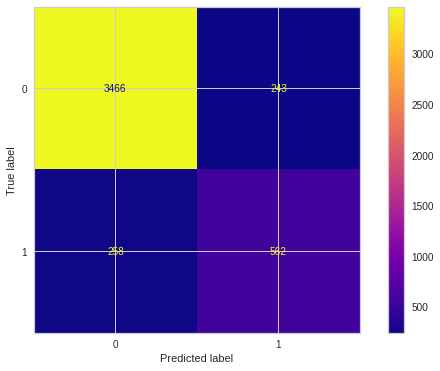

In [247]:
print("NBMulti_Count Model")
print("-------------------")
eval(nbmulti_count, X_train_count, X_test_count)

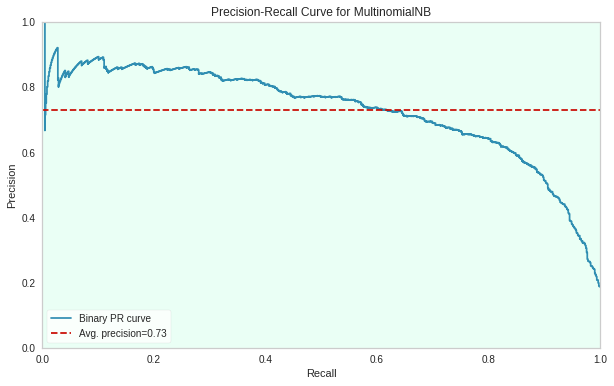

In [248]:
from yellowbrick.classifier import PrecisionRecallCurve

viz = PrecisionRecallCurve(
      MultinomialNB(),
      classes = nbmulti_count.classes_,  
      per_class = True,
      cmap = "Set1")

fig, ax = plt.subplots(figsize = (10, 6))
ax.set_facecolor('#eafff5')

viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [249]:
y_pred = nbmulti_count.predict(X_test_count)
nb_multi_count_rec = recall_score(y_test, y_pred, pos_label = 0, average = None)
nb_multi_count_f1 = f1_score(y_test, y_pred, pos_label = 0, average = None)
nb_multi_count_AP = viz.score_

In [250]:
print("viz.score_         : ", viz.score_)
print("NBMulti_Count_rec : ", nb_multi_count_rec)
print("NBMulti_Count_f1  : ", nb_multi_count_f1)
print("NBMulti_Count_AP  : ", nb_multi_count_AP)

viz.score_         :  0.7282257898302862
NBMulti_Count_rec :  [0.93448369 0.68536585]
NBMulti_Count_f1  :  [0.93259787 0.69169231]
NBMulti_Count_AP  :  0.7282257898302862


In [251]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    model = MultinomialNB()
    scores = cross_val_score(model, X_train_count, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        nbm_count_rec = scores
    elif i == "f1-1":
        nbm_count_f1 = scores
    print(f" {i:20} score for NBMulti_Count : {scores}\n")

 accuracy             score for NBMulti_Count : 0.881791766772349

 precision-0          score for NBMulti_Count : 0.929266610342754

 recall-0             score for NBMulti_Count : 0.9261684536153677

 f1-0                 score for NBMulti_Count : 0.9277051344427043

 precision-1          score for NBMulti_Count : 0.6711258849457677

 recall-1             score for NBMulti_Count : 0.6811939357995405

 f1-1                 score for NBMulti_Count : 0.6759818179703109



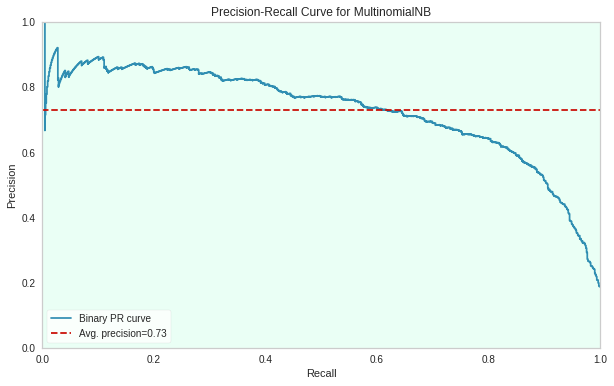

In [252]:
from yellowbrick.classifier import PrecisionRecallCurve

viz = PrecisionRecallCurve(
    MultinomialNB(),
    classes = nbmulti_count.classes_,  
    per_class = True,
    cmap = "Set1"
)

fig, ax = plt.subplots(figsize = (10, 6))
ax.set_facecolor('#eafff5')

viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [253]:
NBMulti_Count_AP = viz.score_
NBMulti_Count_AP

0.7282257898302862

**RandomForest**

In [254]:
from sklearn.ensemble import RandomForestClassifier

rf_count = RandomForestClassifier(n_estimators = 200, max_depth = 11, class_weight = "balanced", random_state = 101, n_jobs = -1)
rf_count.fit(X_train_count, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=11, n_estimators=200,
                       n_jobs=-1, random_state=101)

RF_Count Model
--------------
[[3175  534]
 [ 164  656]]
Test_Set
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      3709
           1       0.55      0.80      0.65       820

    accuracy                           0.85      4529
   macro avg       0.75      0.83      0.78      4529
weighted avg       0.88      0.85      0.86      4529

Train_Set
              precision    recall  f1-score   support

           0       0.97      0.88      0.93     14831
           1       0.63      0.89      0.74      3281

    accuracy                           0.88     18112
   macro avg       0.80      0.89      0.83     18112
weighted avg       0.91      0.88      0.89     18112



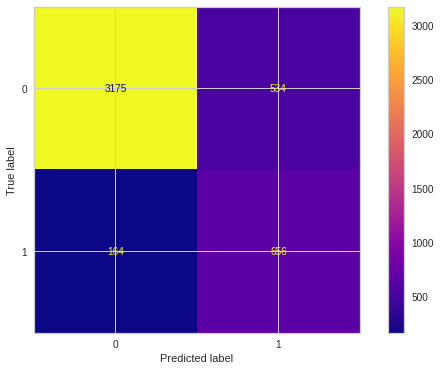

In [255]:
print("RF_Count Model")
print("--------------")
eval(rf_count, X_train_count, X_test_count)

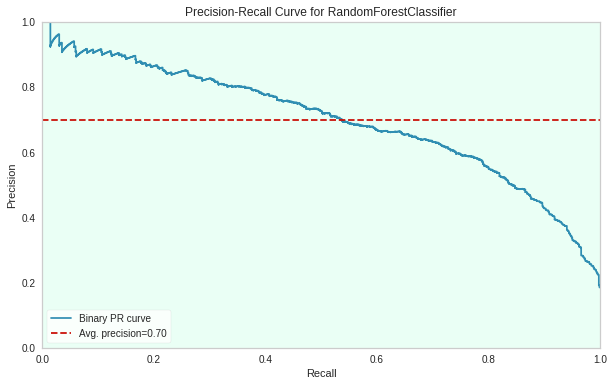

In [256]:
viz = PrecisionRecallCurve(
      RandomForestClassifier(n_estimators = 200, max_depth = 11, class_weight = "balanced", random_state = 101, n_jobs = -1),
      classes = rf_count.classes_,
      per_class = True,
      cmap = "Set1")

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('#eafff5')

viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [257]:
y_pred = rf_count.predict(X_test_count)
rf_count_rec = recall_score(y_test, y_pred, pos_label = 0, average = None)
rf_count_f1 = f1_score(y_test, y_pred, pos_label = 0, average = None)
rf_count_AP = viz.score_

In [258]:
print("viz.score_   : ", viz.score_)
print("RF_Count_rec : ", rf_count_rec)
print("RF_Count_f1  : ", rf_count_f1)
print("RF_Count_AP  : ", rf_count_AP)

viz.score_   :  0.6985344026437313
RF_Count_rec :  [0.85602588 0.8       ]
RF_Count_f1  :  [0.90096481 0.65273632]
RF_Count_AP  :  0.6985344026437313


In [259]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label = 0),
                 'recall-0': make_scorer(recall_score, pos_label = 0),
                 'f1-0': make_scorer(f1_score, pos_label = 0),
                 'precision-1': make_scorer(precision_score, pos_label = 1),
                 'recall-1': make_scorer(recall_score, pos_label = 1),
                 'f1-1': make_scorer(f1_score, pos_label = 1)
                 }

for i, j in custom_scorer.items():
    model = RandomForestClassifier(n_estimators = 200, max_depth = 11, class_weight = "balanced", random_state = 101, n_jobs = -1)
    scores = cross_val_score(model, X_train_count, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        rf_count_rec = scores
    elif i == "f1-1":
        rf_count_f1 = scores
    print(f" {i:20} score for RF_Count : {scores}\n")

 accuracy             score for RF_Count : 0.8500441562050896

 precision-0          score for RF_Count : 0.9484565157823012

 recall-0             score for RF_Count : 0.8638655889842293

 f1-0                 score for RF_Count : 0.9041461483119981

 precision-1          score for RF_Count : 0.5617179066877422

 recall-1             score for RF_Count : 0.7875648676699532

 f1-1                 score for RF_Count : 0.6554933545933405



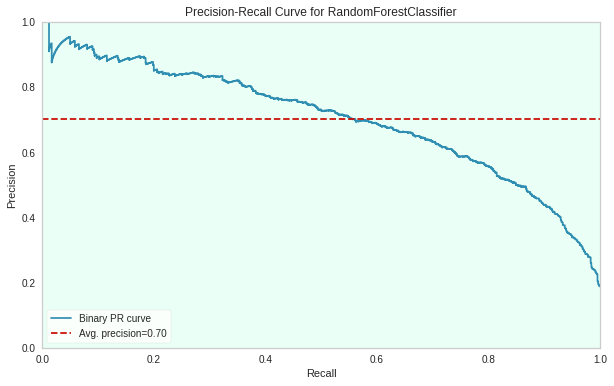

In [260]:
viz = PrecisionRecallCurve(
      RandomForestClassifier(200, max_depth = 12, random_state = 42, n_jobs = -1, class_weight="balanced"),
      classes = rf_count.classes_,
      per_class = True,
      cmap = "Set1")

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('#eafff5')

viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [261]:
RF_Count_AP = viz.score_
RF_Count_AP

0.7023790602771809

In [262]:
compare = pd.DataFrame({"Model": ["NaiveBayes(Multi)_Count","LogReg_Count", "Random Forest_Count"],
                                   
                        "F1_Score": [nbm_count_f1, log_count_f1, rf_count_f1],
                                                 
                        "Recall_Score": [nbm_count_rec, log_count_rec, rf_count_rec],
                        
                        "Average_Precision_Score": [NBMulti_Count_AP, LogReg_Count_AP, RF_Count_AP]})
  
    
compare = compare.sort_values(by="Recall_Score", ascending=True)
compare

,Model,F1_Score,Recall_Score,Average_Precision_Score
0,NaiveBayes(Multi)_Count,0.676,0.681,0.728
2,Random Forest_Count,0.655,0.788,0.702
1,LogReg_Count,0.913,0.873,0.732


In [263]:
compare = compare.sort_values(by="F1_Score", ascending=True)
compare

,Model,F1_Score,Recall_Score,Average_Precision_Score
2,Random Forest_Count,0.655,0.788,0.702
0,NaiveBayes(Multi)_Count,0.676,0.681,0.728
1,LogReg_Count,0.913,0.873,0.732


In [264]:
compare = compare.sort_values(by="Average_Precision_Score", ascending=True)
compare

,Model,F1_Score,Recall_Score,Average_Precision_Score
2,Random Forest_Count,0.655,0.788,0.702
0,NaiveBayes(Multi)_Count,0.676,0.681,0.728
1,LogReg_Count,0.913,0.873,0.732
